# Laboratory work 7: stiff systems of differential equations

---

## Work objective:

Solve a stiff system of differential equatins by:

1) Implicit Runge-Kutta methods;
2) Rosenbrock methods;
3) Implicit Adams methods in Nordsieck's representation.

The example to which these methods were applied is a system of equation modeling glycolysis:

\begin{cases}
    \dot{y}_1 = 1 - y_1 y_2 \\
    \dot{y}_2 = \alpha y_2 \left(y_1 - \frac{1 + \beta}{y_2 + \beta}\right)
\end{cases},

where $\alpha \in \{100, 200, 400, 1000\}$, $\beta = 10$.

Initial values of Cauchy problem are:

\begin{cases}
    y_1(0) = 1\\
    y_2(0) = 0.001
\end{cases}

Segment on which we wish to find the solution: $t \in [0; 50]$.

## Imports

In [250]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

## Given Cauchy problem

In [251]:
x_0 = [1, 0.001]
t_1 = 0
t_2 = 50

Alpha = [100, 200, 400, 1000]
beta = 10

## Runge-Kutta methods

In [252]:
# class to be passed to scipy.optimize.fsolve
class K_System:

    def __init__(self, F, t_n, x_n, dt, A, B, C):

        self._F = F
        self._t_n = t_n
        self._x_n = x_n
        self._dt = dt
        self._order = len(B)
        self._dim = len(x_n)
        self._A = A
        self._B = B
        self._C = C

    def __call__(self, flat_k):

        k = flat_k.reshape((self._order, self._dim))
        ret_val = np.empty_like(k)
        for i in range(self._order):
            ret_val[i] = k[i] - self._F(self._t_n + self._dt * self._C[i],\
                                        self._x_n + self._dt * self._A[i] @ k)
        return ret_val.flatten()

class Runge_Kutta:

    def __init__(self, F, x_0, t_1, t_2, N, A, B, C):

        self._order = len(B)
        if len(C) != self._order:
            raise RuntimeError("The size of B-part of Butcher tableau mismatches the size of C-part")
        if np.shape(A) != (self._order, self._order):
            raise RuntimeError("The size of A-part of Butcher tableau \
                                mismatches sizes of B- and C-parts")
        self._F = F
        self._N = N
        self._dim = len(x_0)
        self._dt = (t_2 - t_1) / N
        self._t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
        self._x = np.empty(shape=(N + 1, self._dim))
        self._x[0] = x_0
        self._A = A.copy()
        self._B = B.copy()
        self._C = C.copy()

    def solve(self, n_steps):

        zeros = np.zeros(self._dim * self._order)
        for n in range(n_steps):
            func = K_System(self._F, self._t[n], self._x[n], self._dt, self._A, self._B, self._C)
            k = fsolve(func, zeros).reshape((self._order, self._dim))
            self._x[n + 1] = self._x[n] + self._dt * self._B @ k

        if n_steps < self._N:
            self._t = np.resize(self._t, n_steps)
            self._x = np.resize(self._x, n_steps)

        return self._t, self._x

## Rosenbrock methods

We will implement CROS scheme (Rosenbrock scheme with complex coefficients):

\begin{equation*}
    \left(\textbf{E} - \frac{1 + i}{2}\tau\textbf{J}\right)\textbf{w} =
    \textbf{f}\left(t_n + \frac{\tau}{2}, \textbf{x}_n\right),
\end{equation*}

\begin{equation*}
    \textbf{x}_{n + 1} = \textbf{x}_n + \tau \cdot Re\textbf{w}
\end{equation*}

where $\textbf{J}$ is jacobian of the system, i.e $\textbf{J}_{i, j} = \left(\frac{\partial f_i}{\partial x_j}\right)\Big\vert_{t = t_n, x = x_n}$.

In [253]:
def partial_derivative (f, t, x, h, j):

    H = np.zeros_like(x)
    H[j] = h
    return 3 * (f(t, x + H) - f(t, x - H)) / (4 * h) \
         - 3 * (f(t, x + 2*H) - f(t, x - 2*H)) / (20 * h) \
             + (f(t, x + 3*H) - f(t, x - 3*H)) / (60 * h)

# here we assume that f is an array of f_0, ..., f_n: R^{n + 1} -> R
def Jacoby_matrix(f, t, x, h):

    m = len(f)
    n = len(x)
    J = np.empty(shape=(m, n))
    for i in range(m):
        for j in range(n):
            J[i, j] = partial_derivative(f[i], t, x, h, j)

    return J

def CROS_method(F, x_0, t_1, t_2, N):

    t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
    dt = (t_2 - t_1) / N

    dim = len(x_0)
    x = np.empty(shape=(N + 1, dim))
    x[0] = x_0

    for n in range(N):
        J = Jacoby_matrix(F, t[n], x[n], dt)
        M = np.eye(dim) - (0.5 + 0.5 * 1j) * dt * J
        f = np.empty(dim)
        for i in range(dim):
            f[i] = F[i](t[n] + dt * 0.5, x[n])

        w = np.linalg.solve(M, f)
        x[n + 1] = x[n] + dt * w.real

    return t, x

## Butcher tableau

We will use the following Butcher tableau for Runge-Kutta method of the 4th order (Gauss–Legendre method):

\begin{array}{ |c|c|c| }
    \hline
    \frac{1}{2} - \frac{\sqrt{3}}{6} & \frac{1}{4} & \frac{1}{4} - \frac{\sqrt{3}}{6} \\[0.7ex]
    \hline
    \frac{1}{2} + \frac{\sqrt{3}}{6} & \frac{1}{4} + \frac{\sqrt{3}}{6} & \frac{1}{4} \\[0.7ex]
    \hline
                                     & \frac{1}{2} & \frac{1}{2} \\[0.7ex]
    \hline
\end{array}

In [254]:
a = np.array([[0.25, 0.25 - np.sqrt(3.0) / 6.0],
              [0.25 + np.sqrt(3.0) / 6.0, 0.25]])
b = np.array([0.5 - np.sqrt(3.0) / 6, 0.5 + np.sqrt(3) / 6])
c = np.array([0.5, 0.5])

## Results

### Drawing graph of a function

In [255]:
def draw(t, x, alpha, label, color):

    plt.figure(figsize = (21, 9), dpi = 100)
    plt.title(f"Solution of glycolysis equations ($\\alpha = {alpha}$)", fontsize = 30)

    plt.xlabel("t", fontsize = 24)
    plt.xticks(fontsize =  20, ha = "center", va = "top")

    plt.ylabel(label, fontsize = 24)
    plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

    plt.scatter(t, x, s = 5, color = color)
    plt.plot(t, x, linewidth = 1, color = color)

    plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
    plt.minorticks_on()
    plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

    plt.show()

### Runge-Kutta method

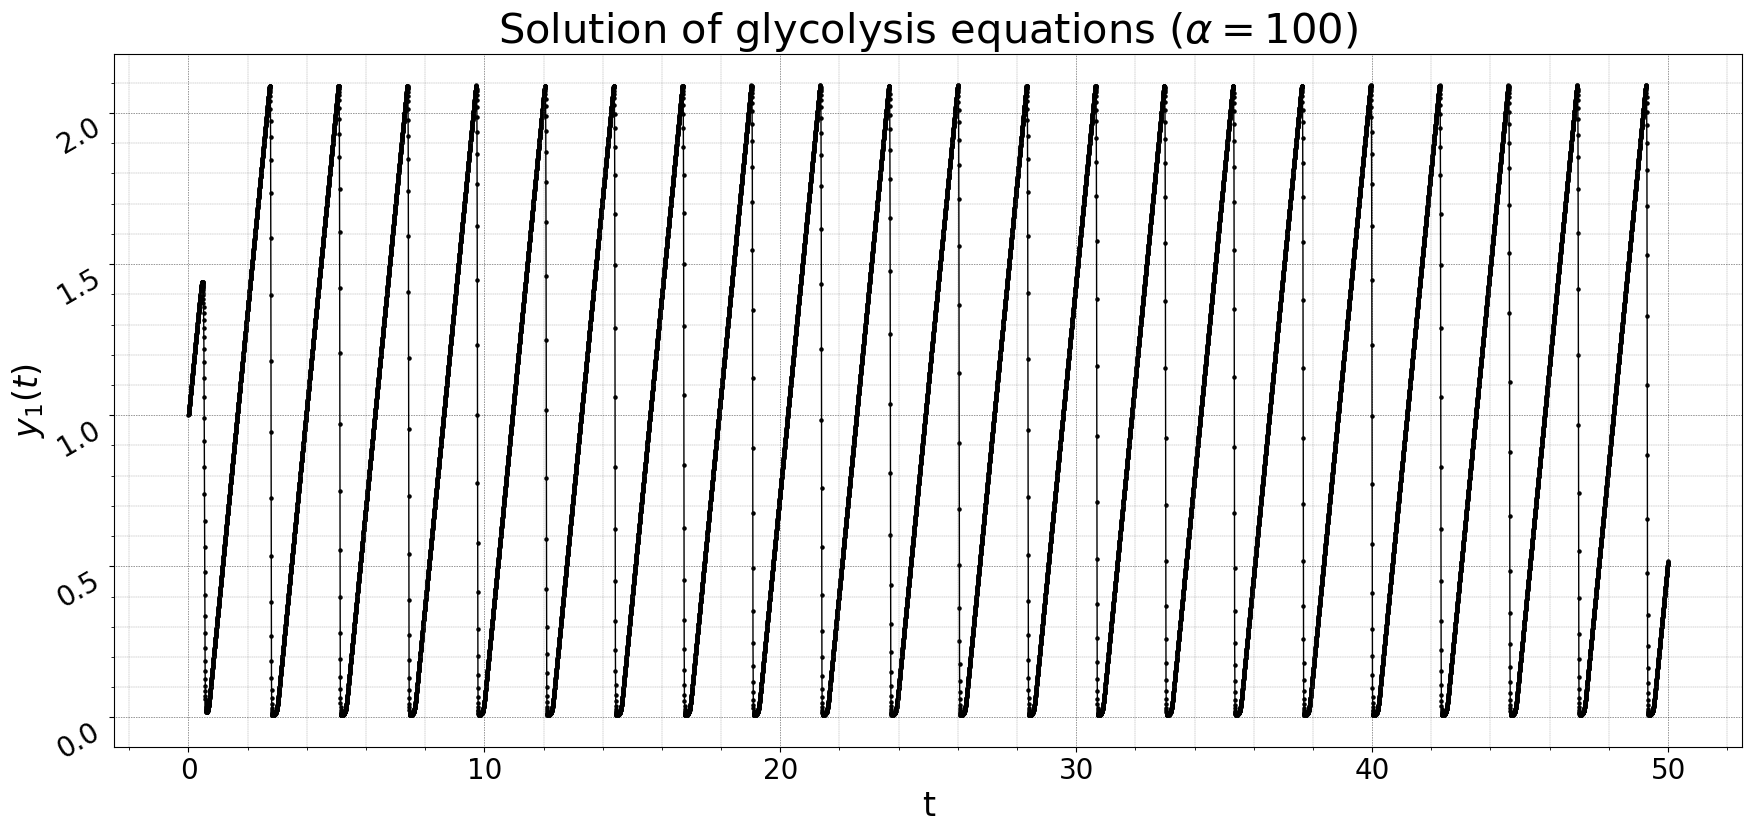

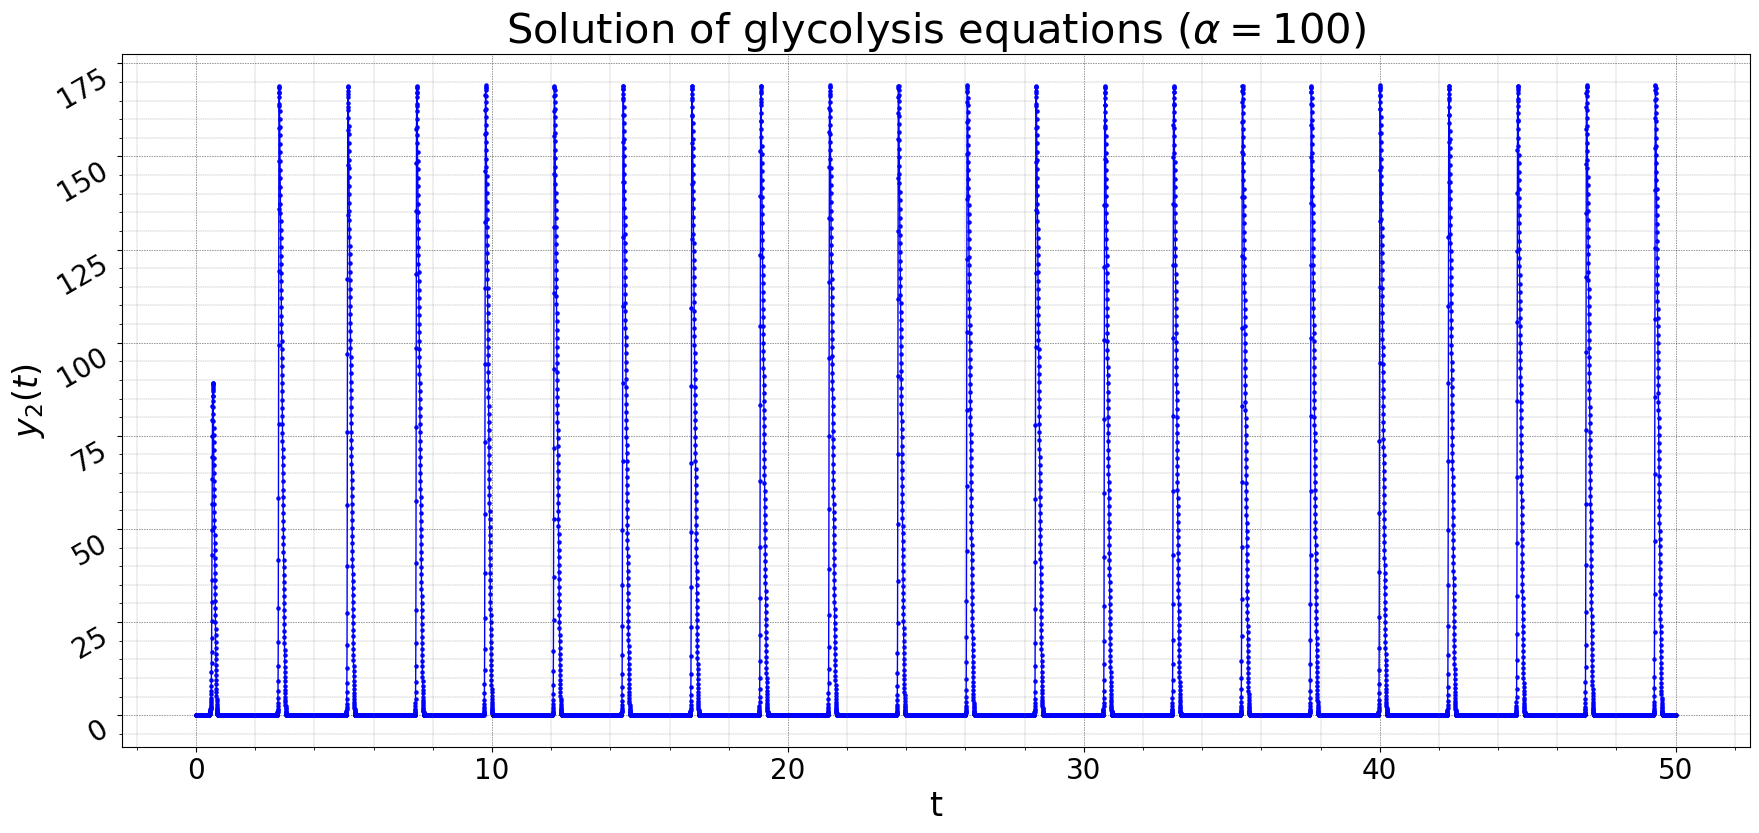

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


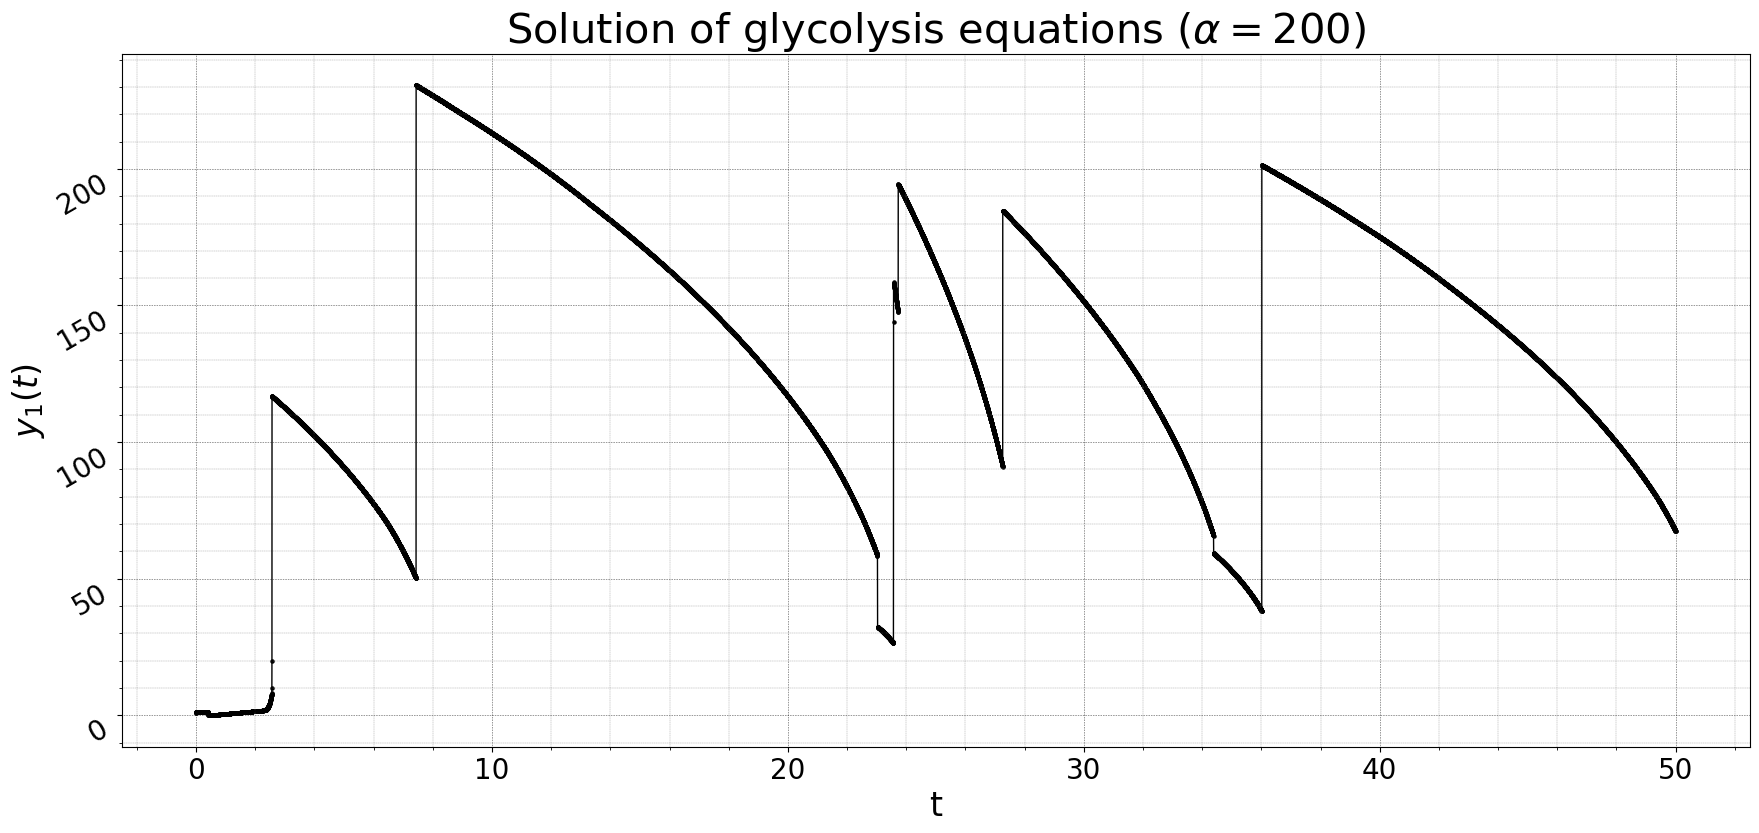

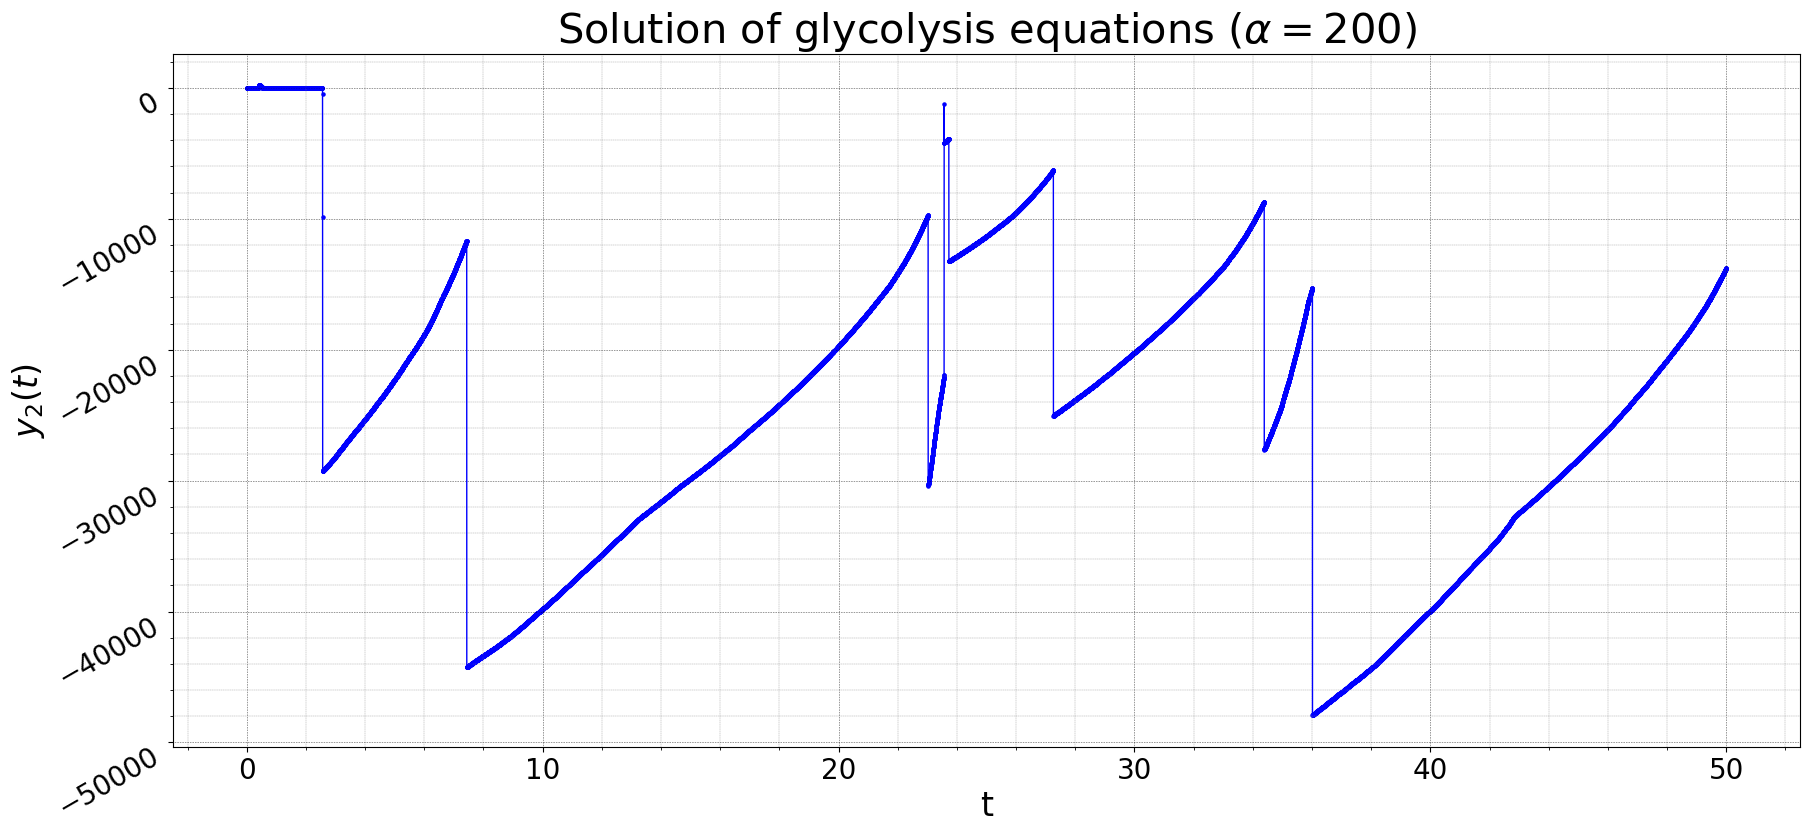

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


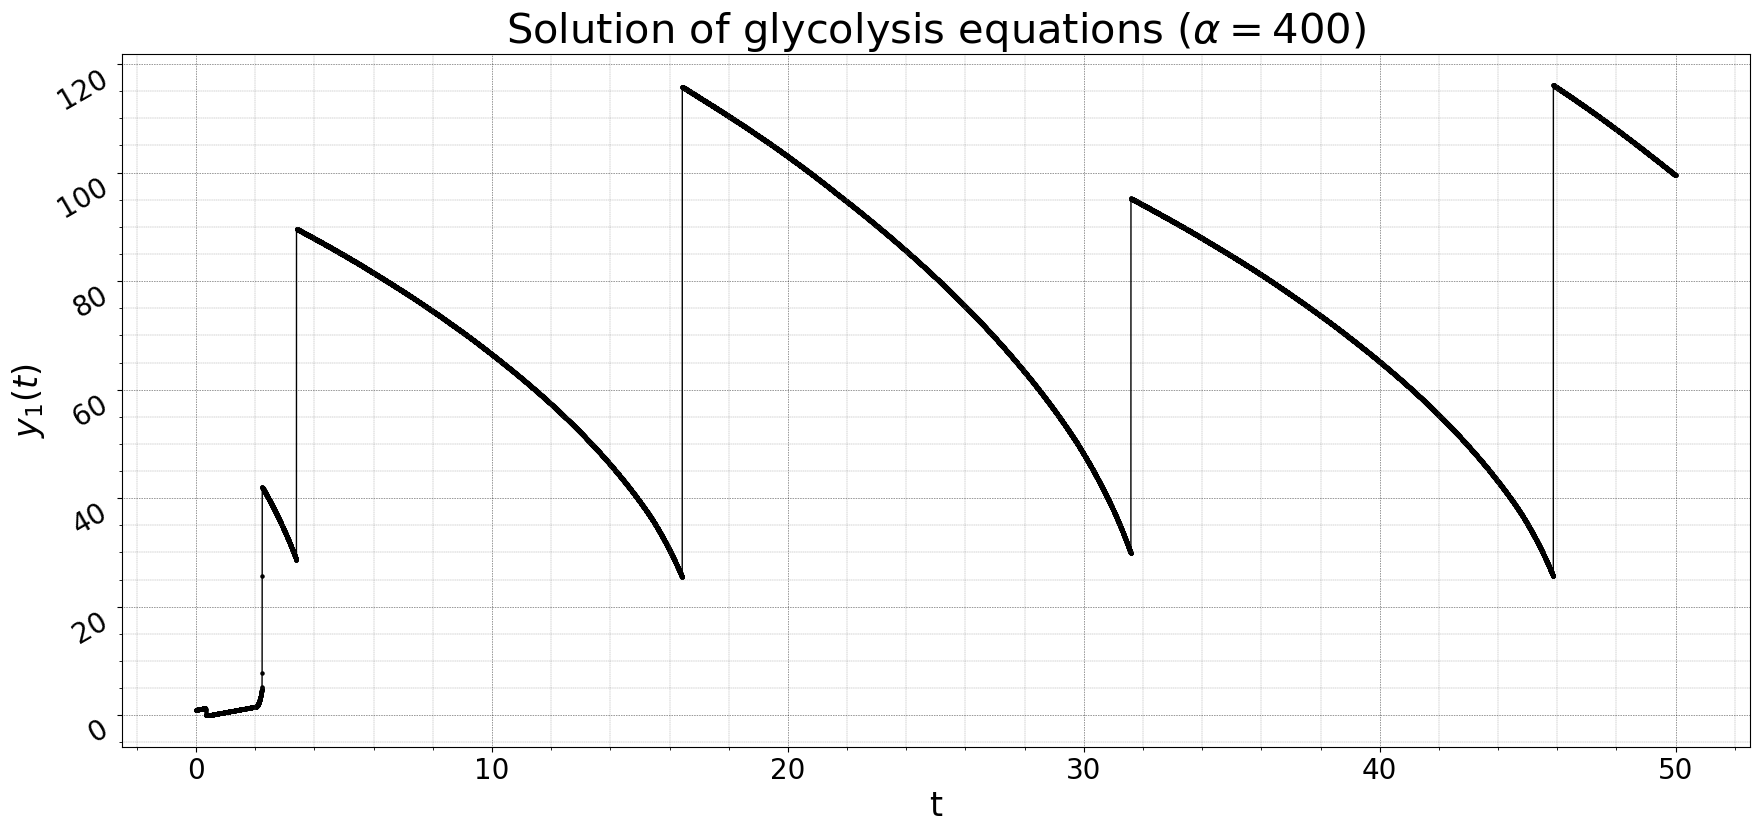

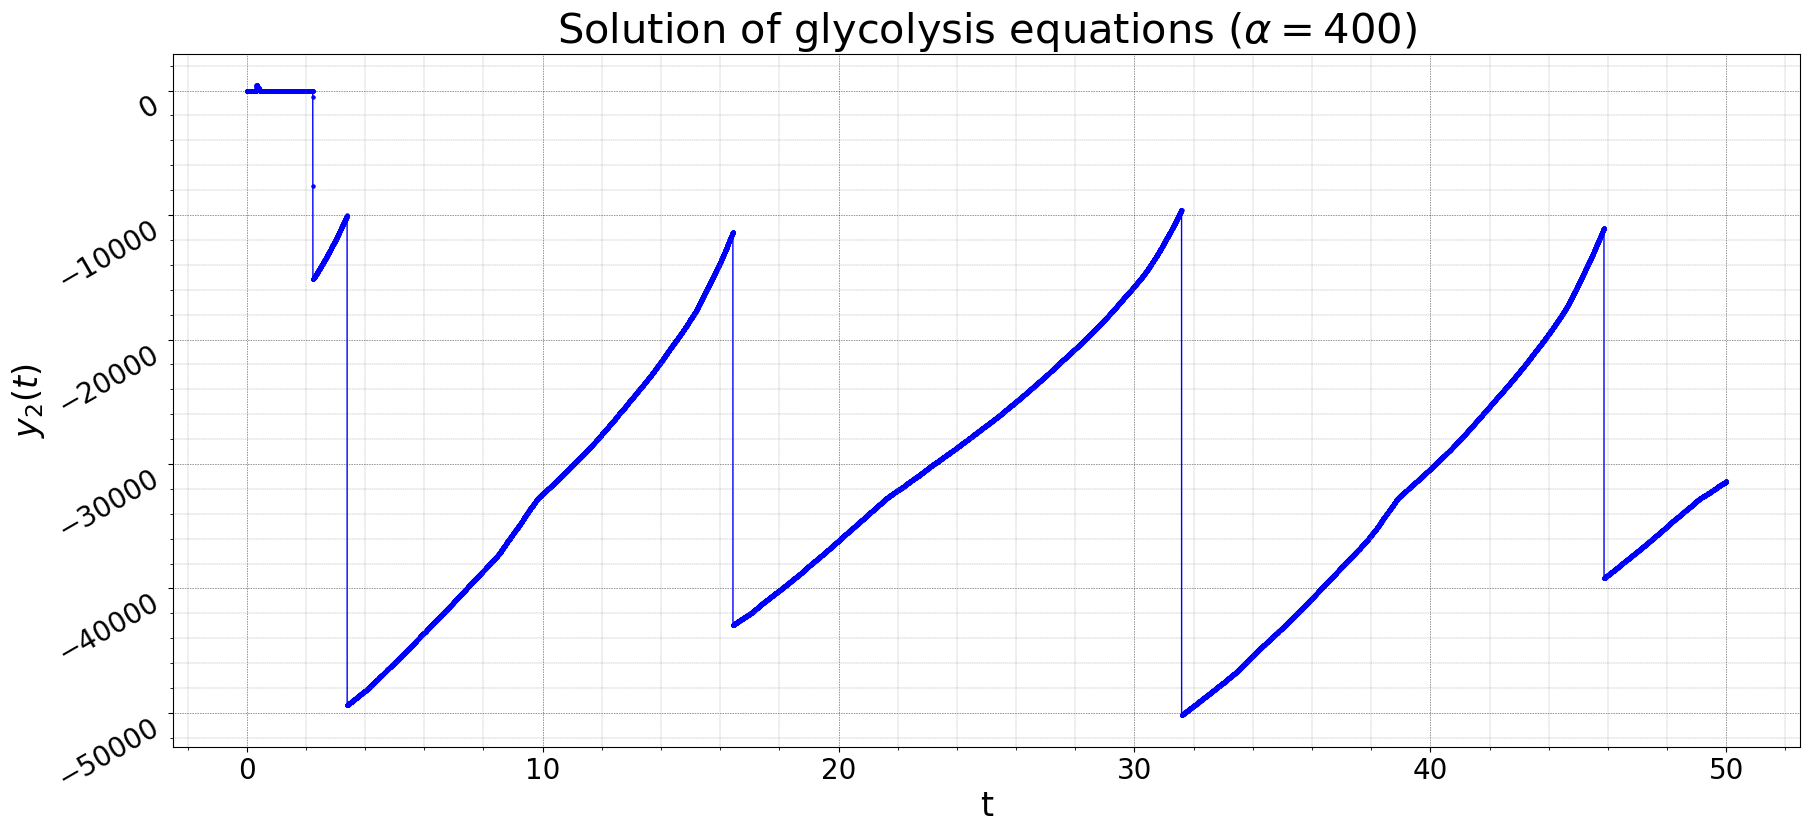

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


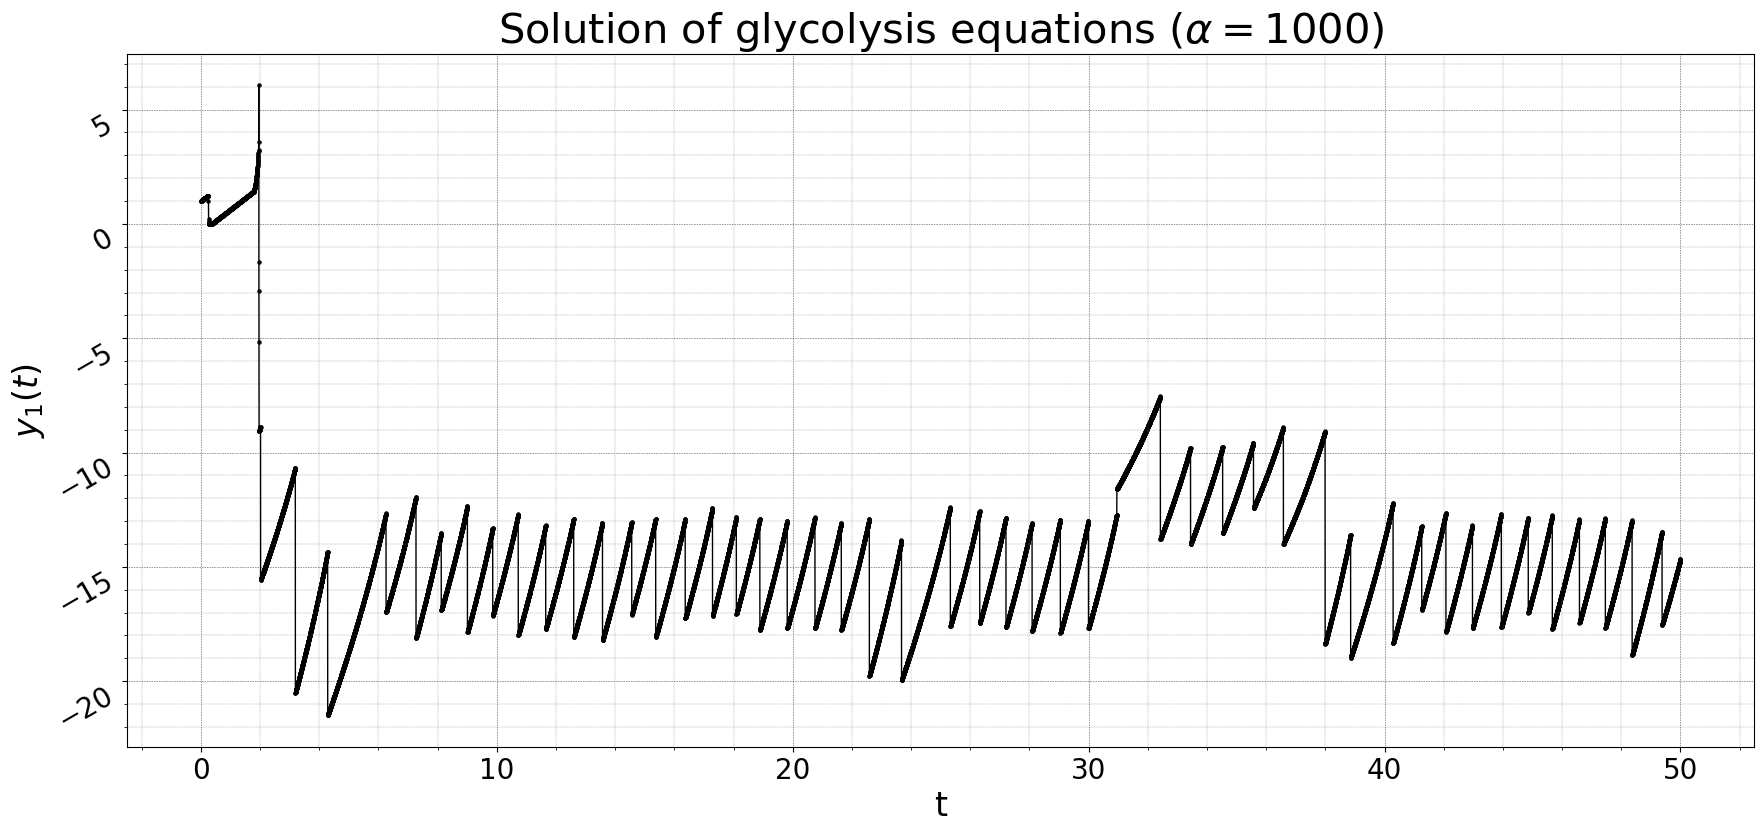

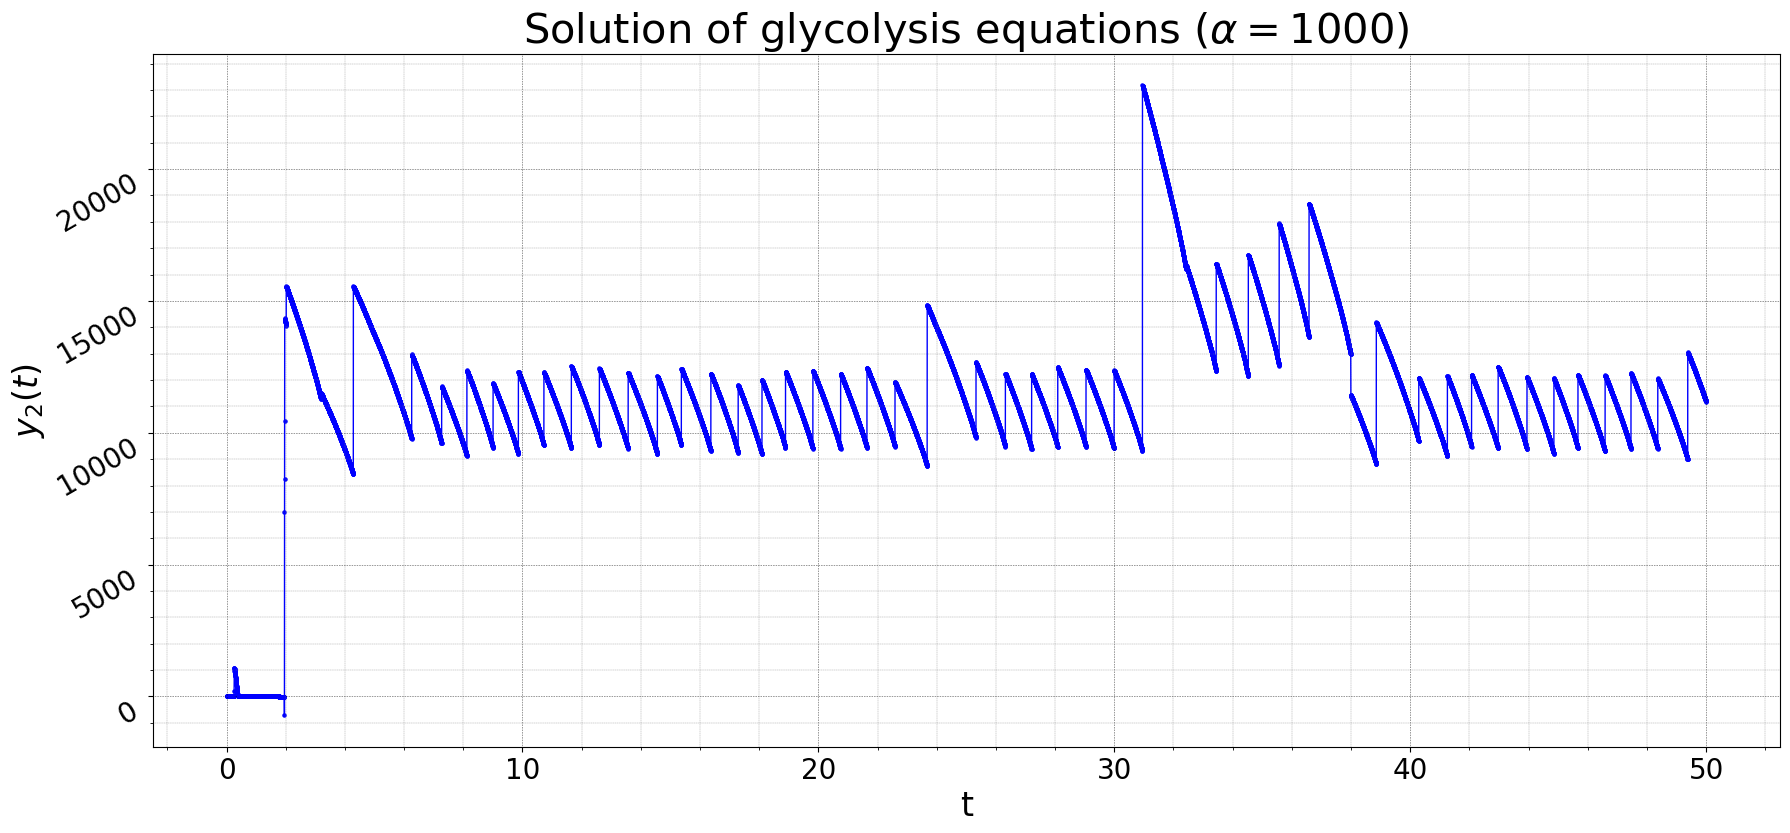

In [256]:
N = 20000

for alpha in Alpha:
    F = lambda t, x: np.array([1 - x[0] * x[1], \
                               alpha * x[1] * (x[0] - (1 + beta) / (x[1] + beta))])
    rk = Runge_Kutta(F, x_0, t_1, t_2, N, a, b, c)
    t, x = rk.solve(N)
    x = x.transpose()
    draw(t, x[0], alpha, label="$y_1(t)$", color="black")
    draw(t, x[1], alpha, label="$y_2(t)$", color="blue")

### Rosenbrock method

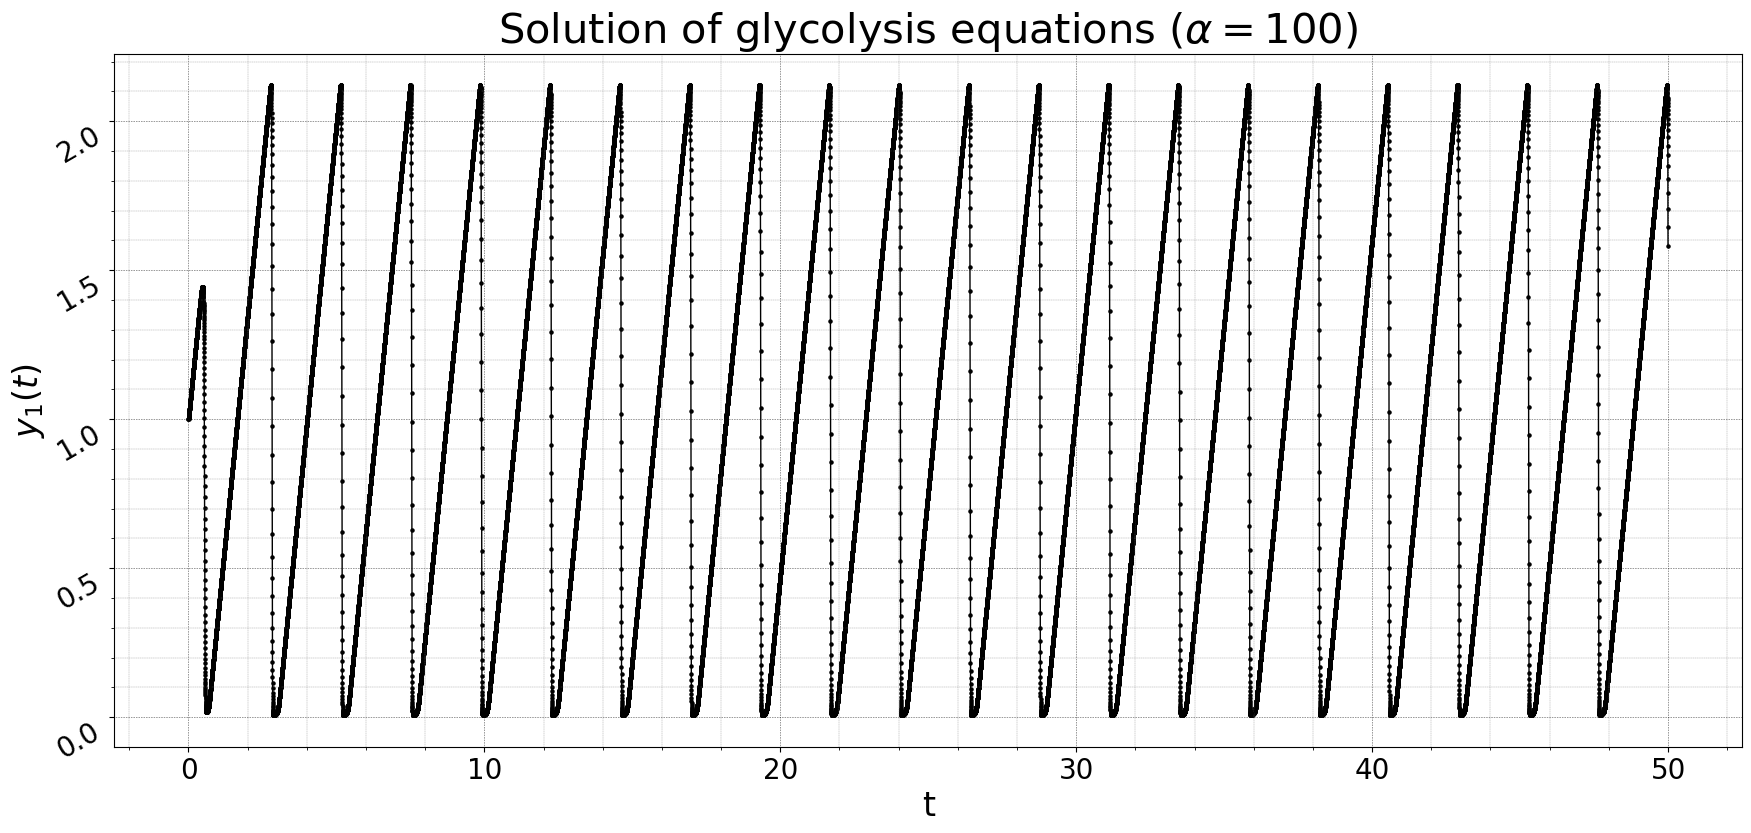

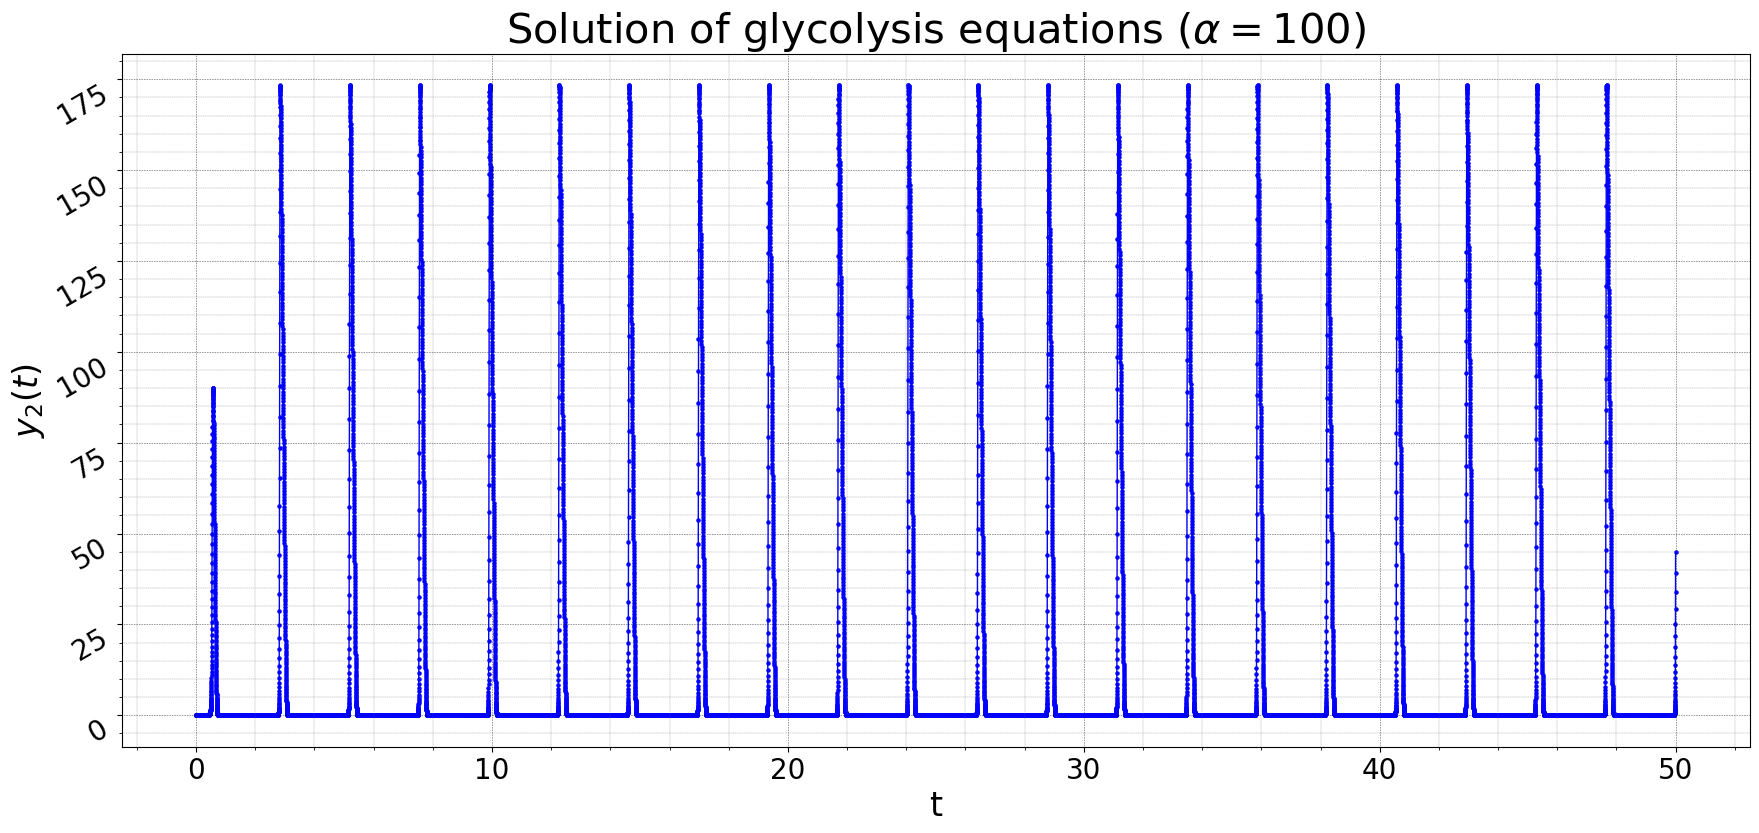

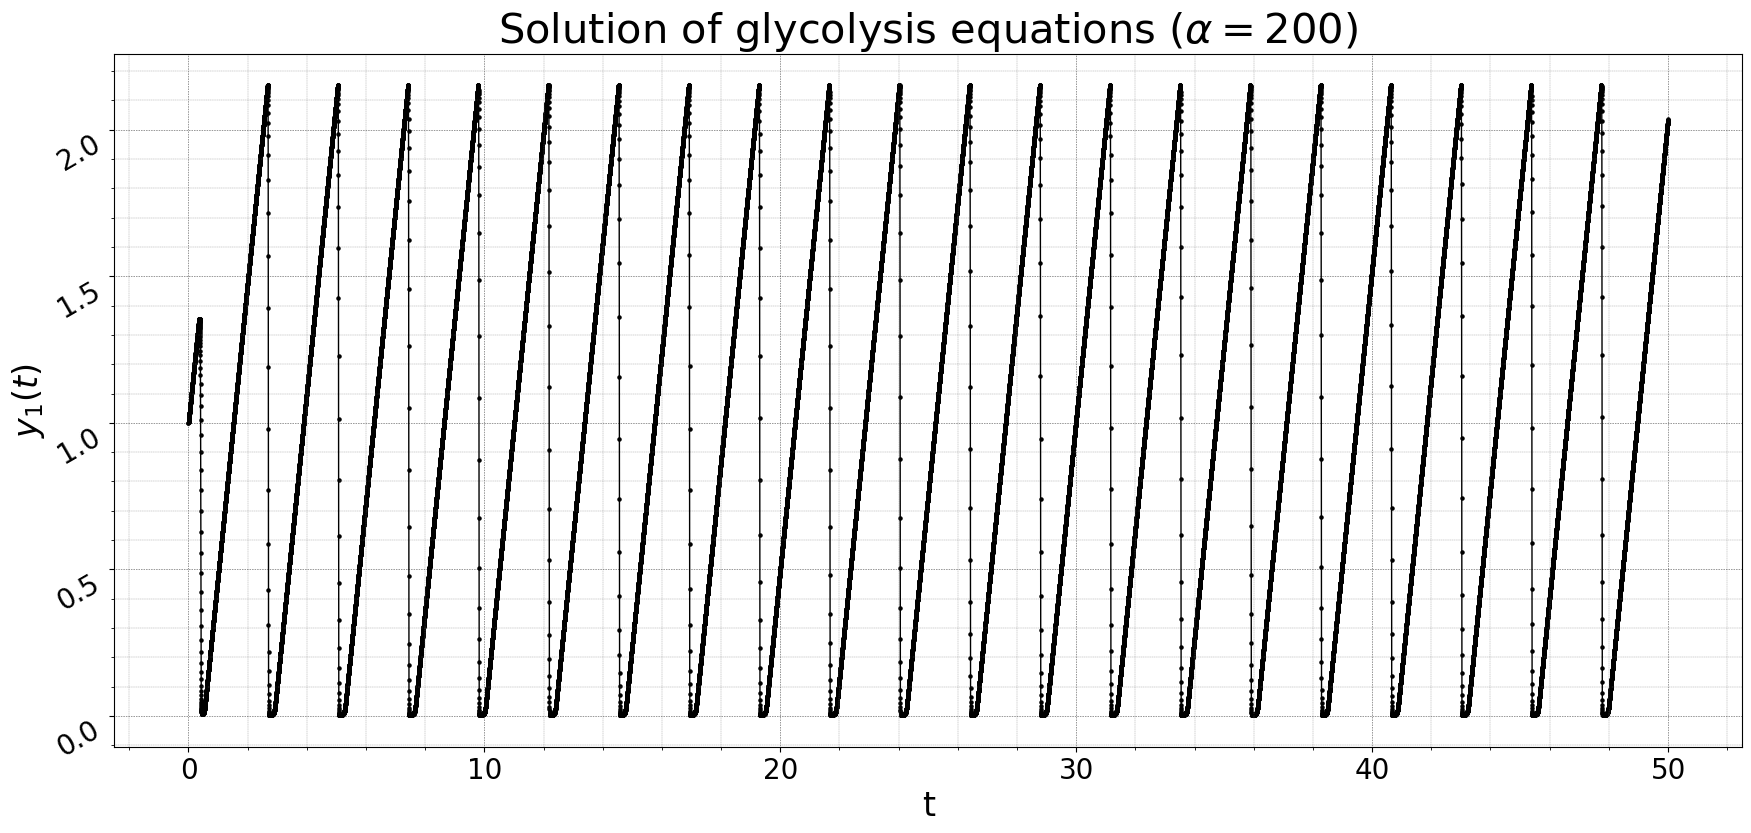

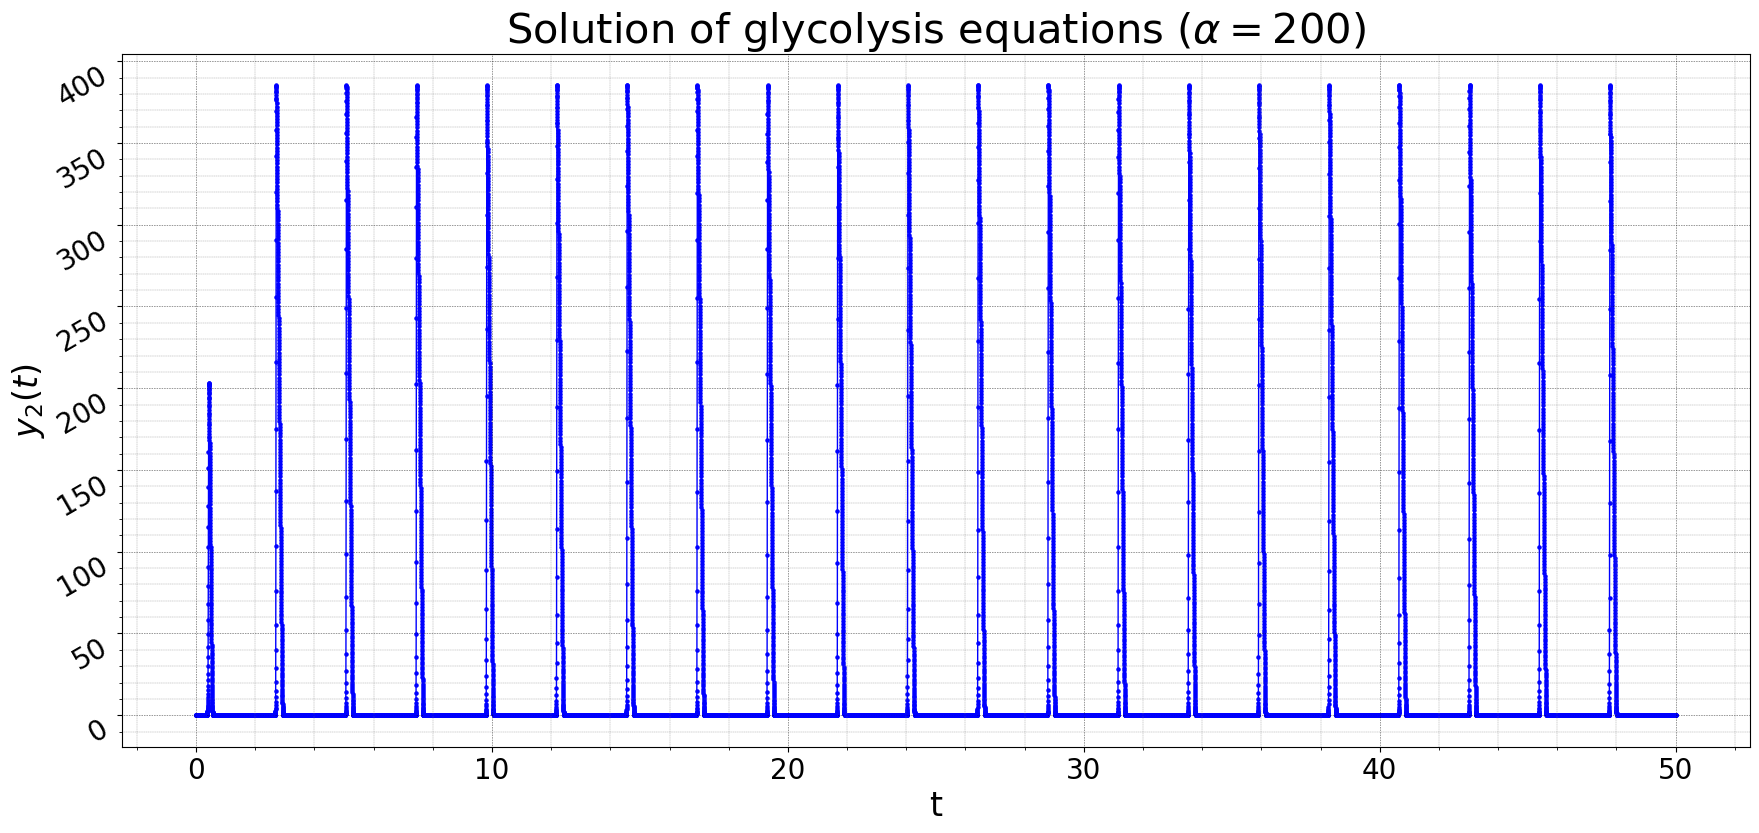

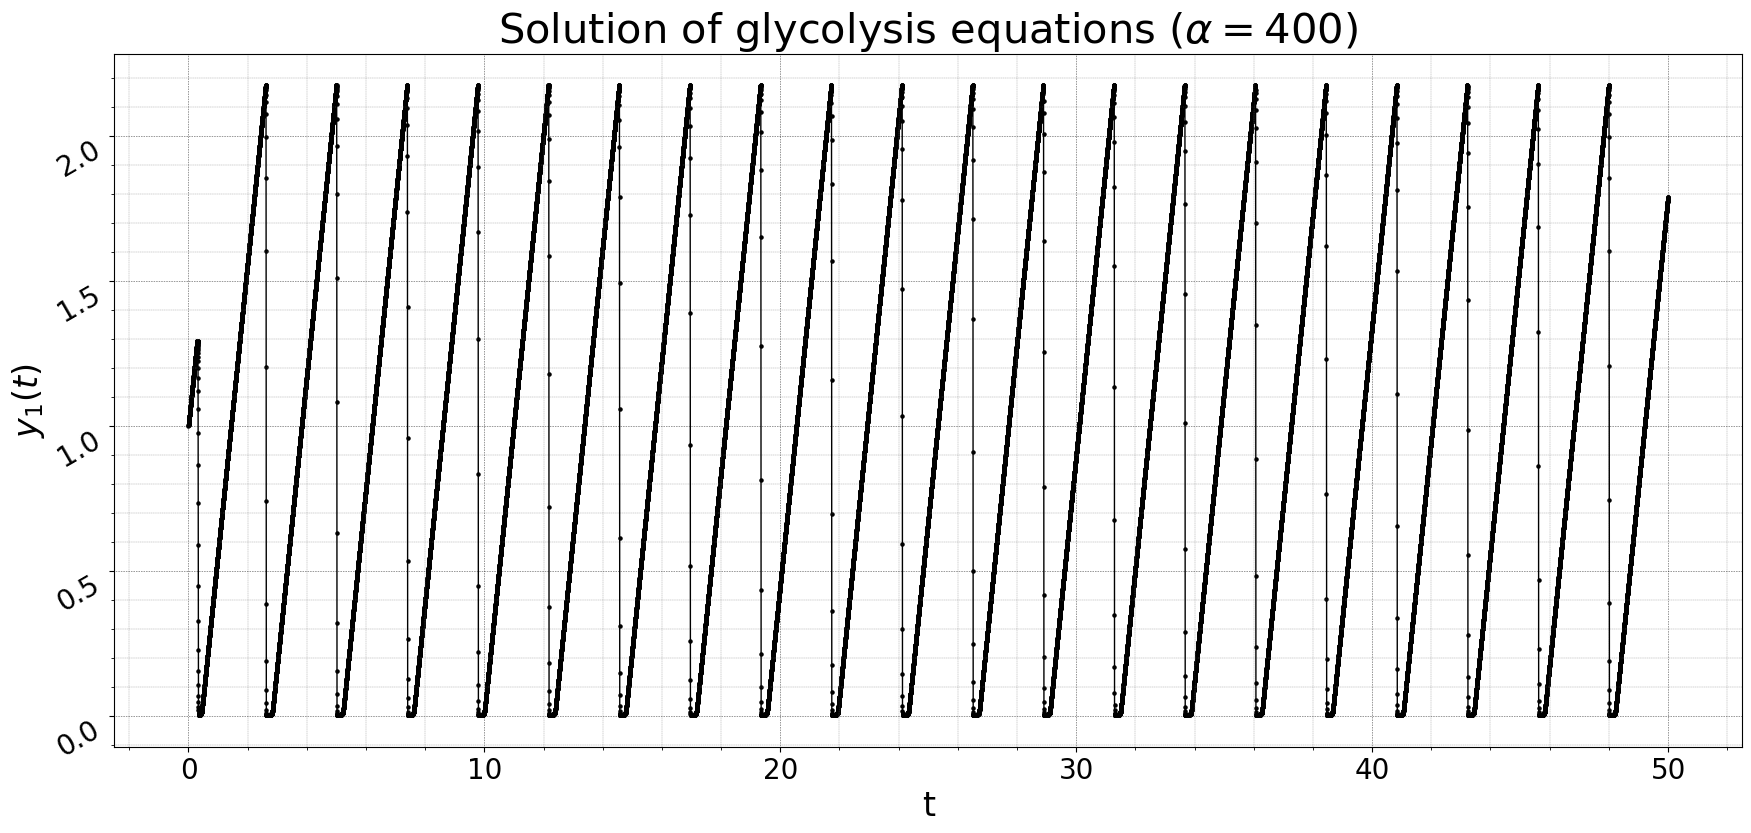

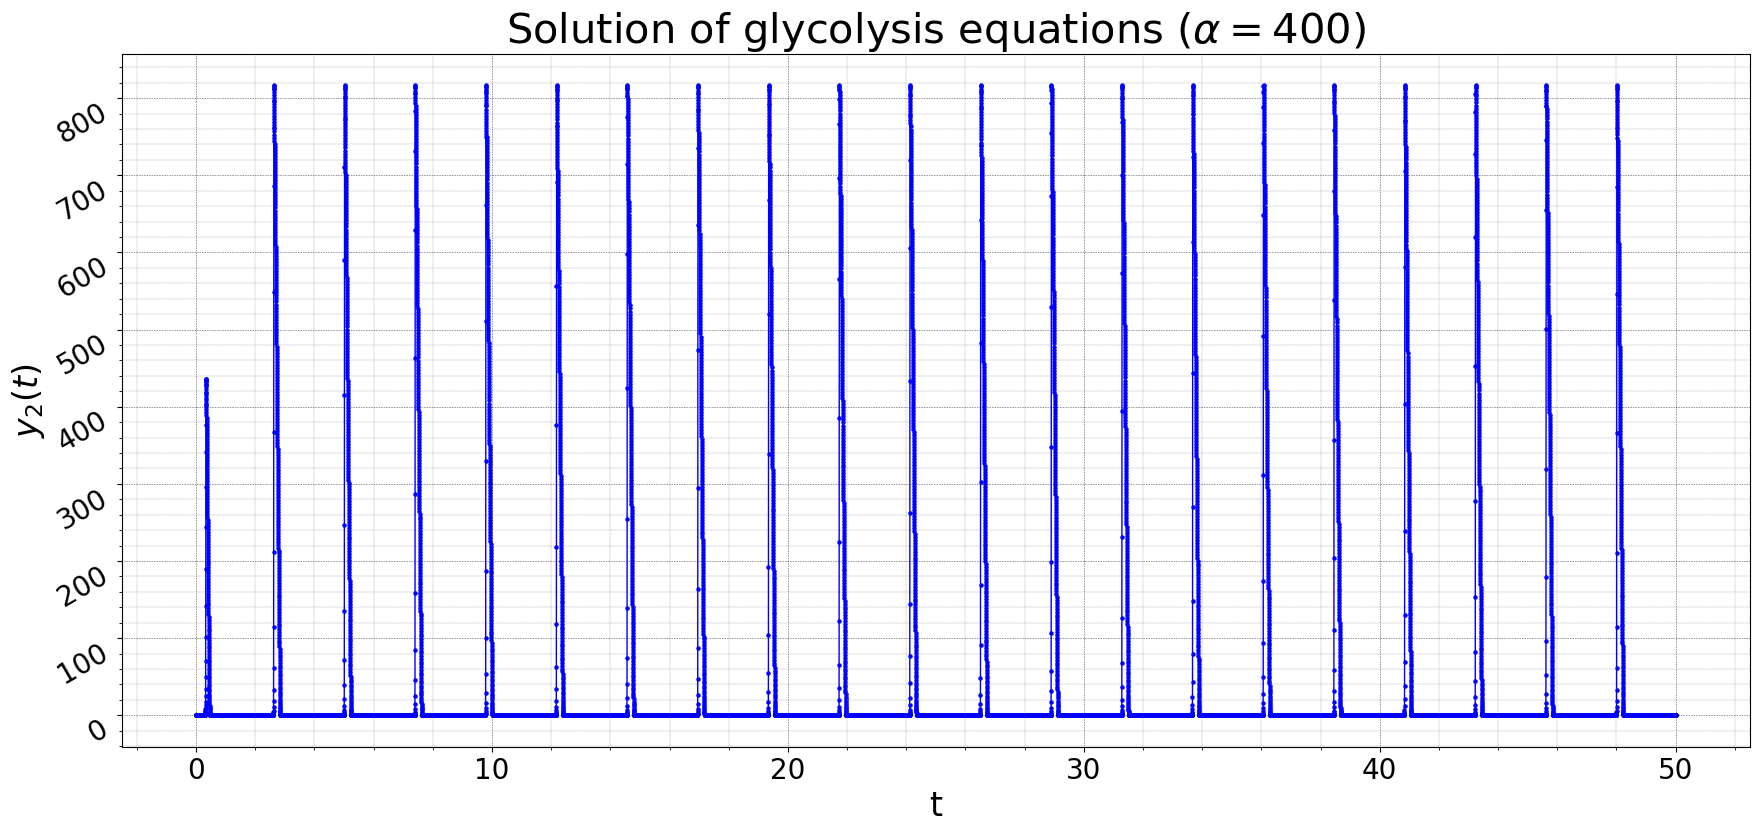

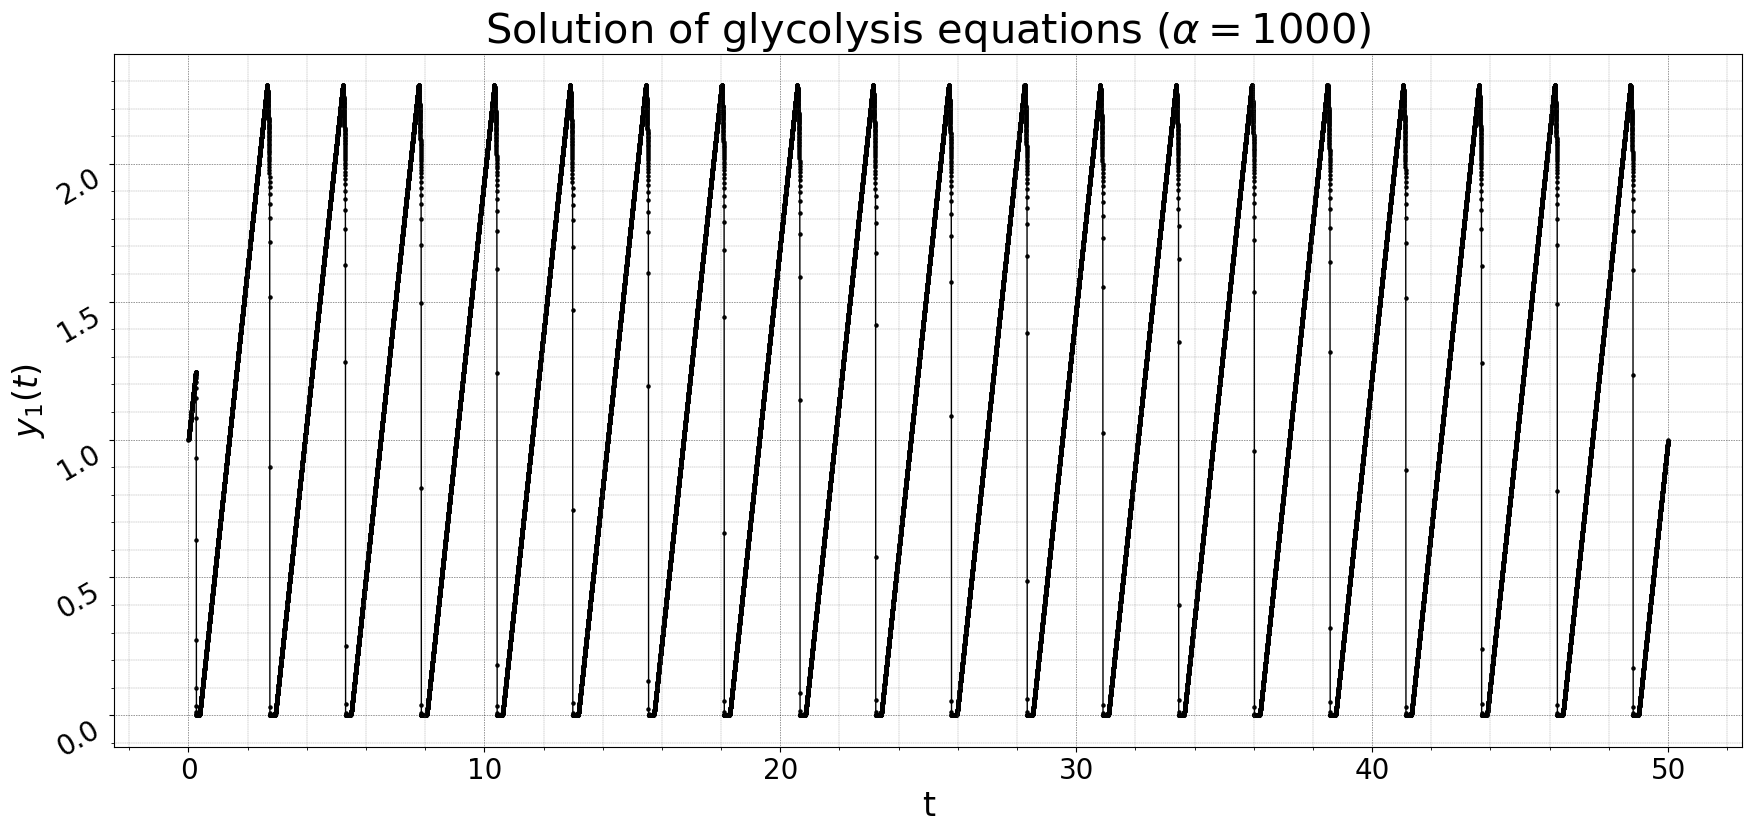

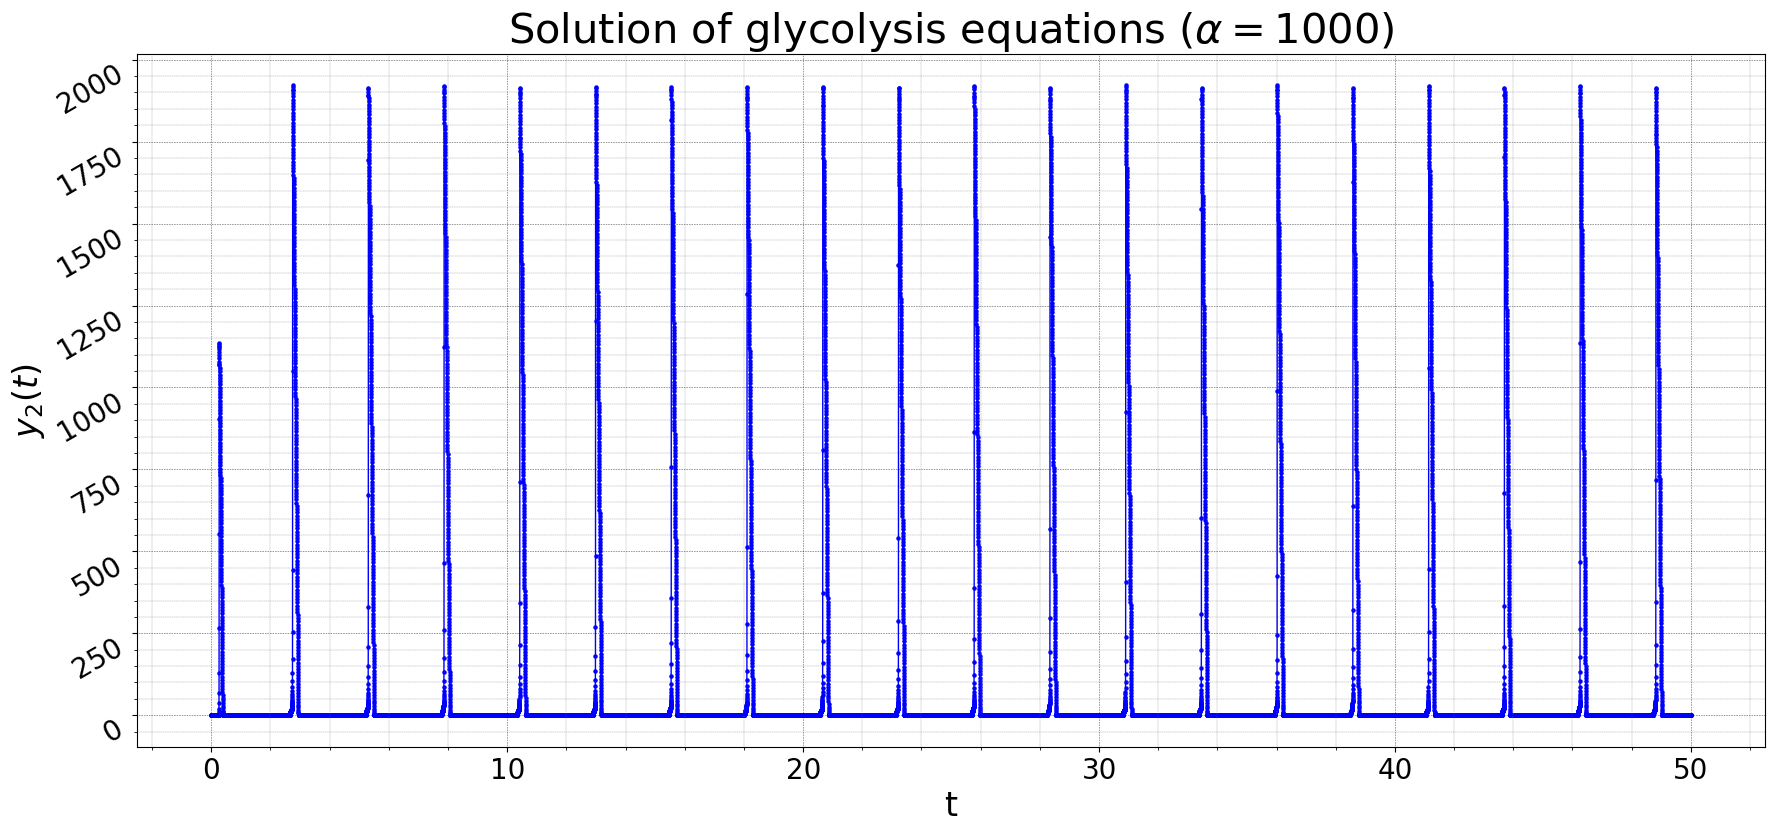

In [257]:
N = 50000

for alpha in Alpha:
    f_1 = lambda t, x: 1 - x[0] * x[1]
    f_2 = lambda t, x: alpha * x[1] * (x[0] - (1 + beta) / (x[1] + beta))
    t, x = CROS_method([f_1, f_2], x_0, t_1, t_2, N)
    x = x.transpose()
    draw(t, x[0], alpha, label="$y_1(t)$", color="black")
    draw(t, x[1], alpha, label="$y_2(t)$", color="blue")